# Open Traffic Reporter: Map-Matching Validation

## 0. Setup Test Environment

In [2]:
from __future__ import division
from matplotlib import pyplot as plt
from matplotlib import cm, colors, patheffects
import numpy as np
import os
import glob
import urllib
import json
import pandas as pd
from random import shuffle, choice
import pickle
import sys; sys.path.insert(0, os.path.abspath('..'));
import validator.validator as val
%matplotlib inline

#### user vars

In [3]:
mapzenKey = os.environ.get('MAPZEN_API')
gmapsKey = os.environ.get('GOOGLE_MAPS')

## 1. Generate Random Routes

In [5]:
cityName = 'San Francisco'
minRouteLen = 1     # specified in km
maxRouteLen = 5     # specified in km
numRoutes = 100

#### Using Mapzen Venues (requires good [WOF](https://whosonfirst.mapzen.com/) coverage):

In [6]:
routeList = val.get_routes_by_length(cityName, minRouteLen, maxRouteLen, numRoutes, apiKey=mapzenKey)

#### Using Google Maps POIs (better for non-Western capitals):

In [4]:
# routeList = val.get_POI_routes_by_length(cityName, 1, 5, 10, gmapsKey)

#### Or load a specific set of routes you've already saved

In [20]:
# routeList = pickle.load(open('{0}_100_routes.pkl'.format('San Francisco'),'rb'))

#### Optionally save route list for future use

In [9]:
pickle.dump(routeList, open('{0}_10_routes.pkl'.format(cityName),'wb'))

## 2. Iterate Through Routes and Score the Matches

#### Define the noise levels and sample rates used to generate synthetic GPS traces from the routes

In [4]:
sampleRates = [1, 5, 10, 20, 30]    # specified in seconds
noiseLevels = np.linspace(0, 100, 21)    # specified in meters

#### Generate the scores

Behind the scenes, the `get_route_metrics()` function will perform the following actions:
1. resample points along a given route at the sample rate(s) specified in the previous cell
2. apply gaussian noise to each of the resample points by sampling from a distribution with mean value(s) specified in the previous cell to sythesize a GPS trace along this route
3. pass these synthetic measurements to the Open Traffic Reporter and record the matches it returns
4. compare the segments on the "matched" route to the segments of the original route and score the results based on six different metrics explained below

In [5]:
matchDf, _ = val.get_route_metrics(routeList, sampleRates, noiseLevels, saveResults=False)

#### Save your results

The previous step will typically take a long time to run if you are generating a lot of routes (> 10), so it's a good idea to save your dataframes for later use.

In [9]:
matchDf.to_csv('sf_100_matches.csv', index=False)

#### Load prior output if you have any

In [7]:
matchDf = pd.read_csv('sf_100_matches.csv')

### Check for Pattern Failure 

Ensure that the Reporter is not failing frequently for any particular sample rate or noise level

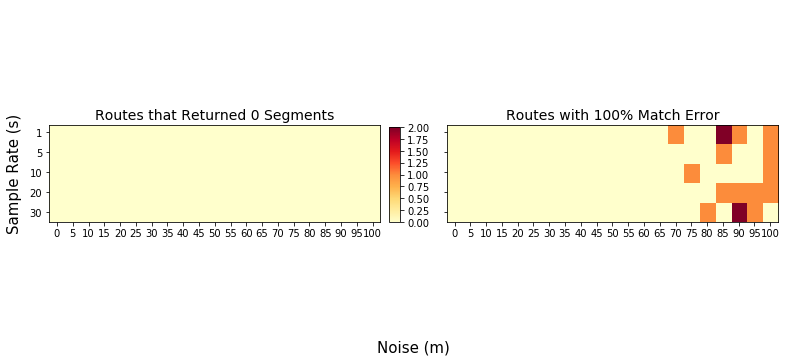

In [5]:
val.plot_pattern_failure(matchDf, sampleRates, noiseLevels)

## 3. Visualize the Scores

### Distance-based Metrics

##### A measure of distance-based map matching error borrowed from [Newton and Krumm (2009)](http://research.microsoft.com/en-us/um/people/jckrumm/Publications%202009/map%20matching%20ACM%20GIS%20camera%20ready.pdf):

<img src="krumm_newson_dist.png" alt="Drawing" style="width: 400px;" align="center"/>

Plots in the left column below represent match scores based solely on segment ID, where "undermatches" denote the percentage of segments in the original route not identified during map matching (false negatives), and "overmatches" refer to segments identified during map matching that were not a part of the original route (false positives). The right-hand column shows the same metrics as the left, but weighted by segment length as a percentage of the total route trace. In other words, for the distance-weighted metrics, a mismatched segment 2 km in length penalizes the match score by twice as much as a 1 km segment. 

For reference, the graph on the top right ("distance traveled") corresponds to Newton and Krumm's (2009) metric as depicted in the image above. We will return to this metric later for use in optimizing the map-matching algorithm.

The `plot_distance_metrics()` function plots the median error rate for each synthetic route at each sample rate/noise level value pair. Thus, the more routes that you've aggregated, the smoother your curves will be.

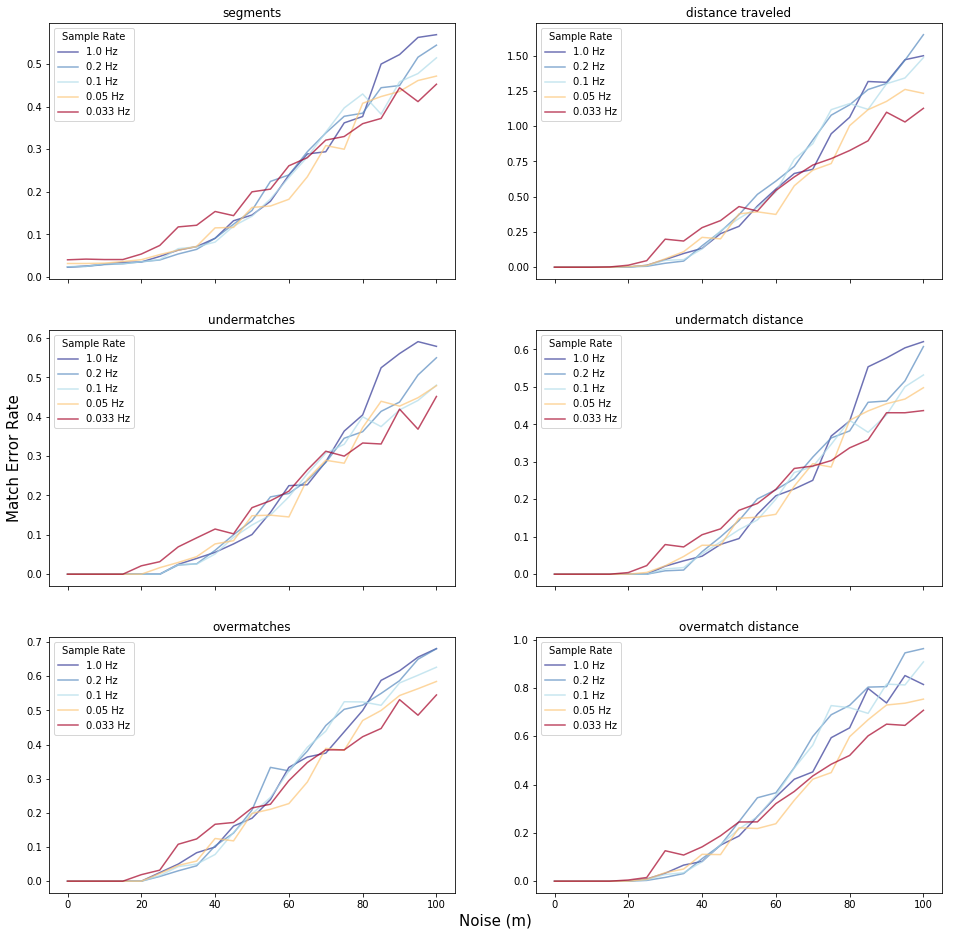

In [7]:
val.plot_distance_metrics(matchDf, sampleRates)

Worth noting in the graphs above are the very consistent points of inflection about which error for low sample rate GPS traces (red) improves relative to that of higher sample rate measurements (blue). The inflection point occurs at ~70 m of noise across almost all of our metrics, and is consistent with the findings of Newton and Krumm (2009). These results suggest that lower sample rates tend to be more robust against mismatch error at higher levels of noise (> 60 m).

## 4. Optimize Map-Matching Parameters

The Open Traffic Reporter map-matching service is based on the Hidden Markov Model (HMM) design of [Newton and Krumm (2009)](http://research.microsoft.com/en-us/um/people/jckrumm/Publications%202009/map%20matching%20ACM%20GIS%20camera%20ready.pdf). Skipping over 99% of the innerworkings of HMMs, there are two probability-related parameters in the HMM algorithm that should be estimated from data (for more detail see [here](https://en.wikipedia.org/wiki/Hidden_Markov_model)):

## $\sigma_z$

The first parameter that needs tuning is $\sigma_z$. It appears in the equation below which expresses the probability of recording the GPS measurement $z_t$ from road segment $r_i$, where $x_{t,i}$ is the point on road segment $r_i$ nearest the measurement $z_t$. 

### $$ p(z_t|r_i) = \frac{1}{\sqrt{2 \pi \sigma_z}} e^{-0.5(\frac{||z_t - x_{t,i}||_{\text{great circle}}}{\sigma_z})^2}$$

In practice, $\sigma_z$ can be thought of as an estimate of the standard deviation of the GPS noise. The more we trust our measurements, the lower our $\sigma_z$ should be. Newton and Krumm (2009) derive their value of $\sigma_z$ from the median absolute deviation over their dataset, arriving at a value of 4.07 m. 

## $\beta$

The second estimated parameter, $\beta$, comes from the exponential distribution. Newton and Krumm found that the distribution of differences between "great circle" distances (also known as "as-the-crow-flies" distance) and map-matched route distance traveled closely resembles that of an exponential probability distribution: 

### $$p(d_t) = \frac{1}{\beta}e^{\frac{-d_t}{\beta}} $$

where $d_t$ is the difference between the great circle distance and route distance traveled between time $t$ and $t+1$, and $\beta$ is the "scale" parameter (or inverse rate) of the exponential distribution. In this context, $\beta$ can be thought of as the expected difference between great circle distances and route distance traveled. Newton and Krumm use a different robust estimator taken from statistics literature to estimate this value from data.

### Grid search to find optimal parameter values

An alternative to explicitly estimating these values from data is search the feasible parameter space and store the values that result in the optimal match scores. This is a common machine learning approach for algorithm optimization, typically referred to as a grid search or parameter sweep. Here, we perform a grid search for each of our specified sample rates so that we can store the optimal parameter values for each one.

#### Define search space

Because this grid search takes place in such high dimensional space ($\text{noise levels} \times \text{sample rates} \times \beta \ \text{values} \times \sigma\  \text{values} \times \text{number of routes}$), it is recommended to use a smaller number of discrete noise levels for the section of the analysis (< 10). Rather than estimating match scores in increments of 5 m of noise, we use increments of 20 below

In [19]:
noiseLevels = np.linspace(0, 100, 6)   # in meters
sampleRates = [1, 5, 10, 20, 30]   # in seconds
betas = np.arange(0.5, 10.5, 0.5)   # no units
sigmaZs = np.arange(0.5, 10.5, 0.5)    #no units

#### Search and score

`grid_search_hmm_params()` will iterate through the sample rates, noise levels, $beta$ values and $sigma_z$ values for each of the sythetic routes that have already been generated. Because this process can be so slow, the results are saved incrementally in the background, and will be recombined in a later step.

In [3]:
val.grid_search_hmm_params(cityName, routeList, sampleRates, noiseLevels, betas, sigmaZs)

#### Recombine the route-specific parameter sweep scores

In [17]:
path ='../data'
allFiles = glob.glob(path + "/*.csv")
frame = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0)
    list_.append(df)
frame = pd.concat(list_)

#### Visualize results

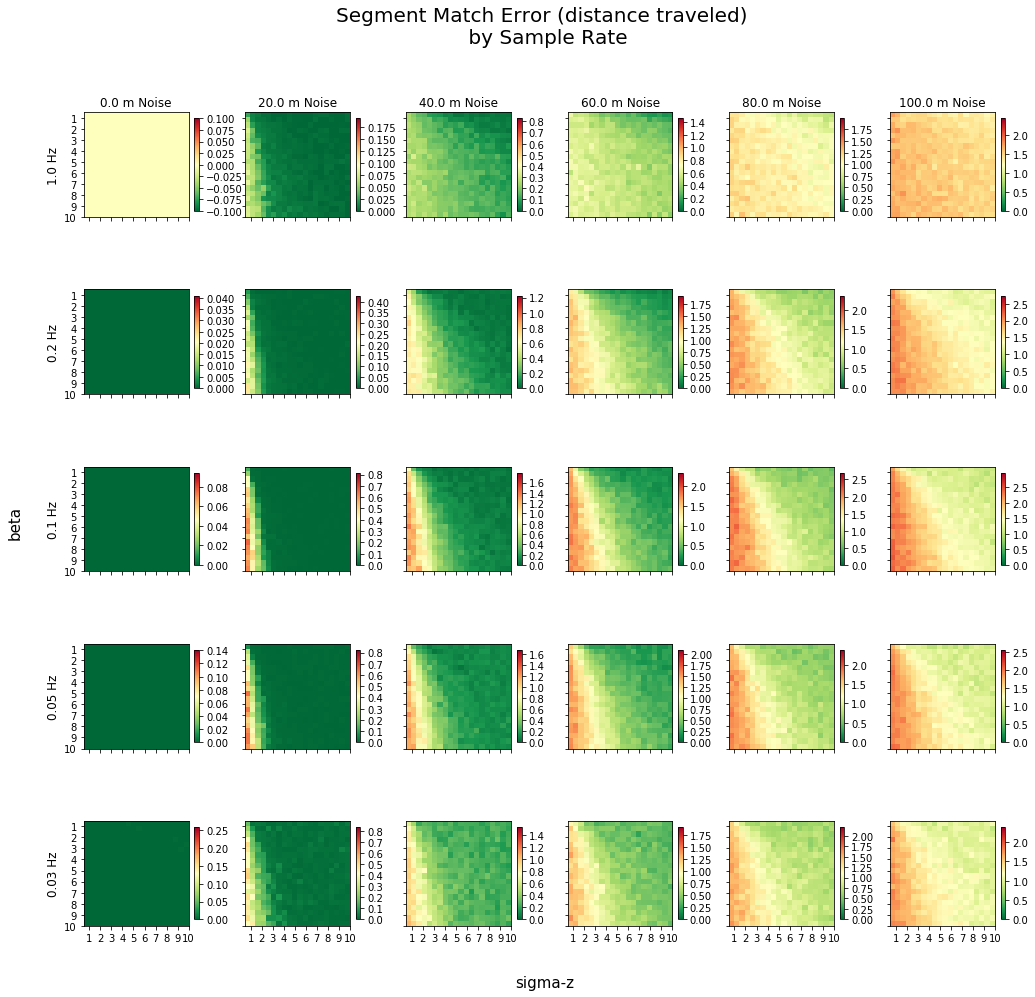

In [20]:
paramDict = val.plot_param_scores(frame, sampleRates, noiseLevels, betas, sigmaZs)

Although there is clearly no one set of optimal parameter values, the results suggest that the default $\beta$ of 3 is probably close to optimal, while the default $\sigma_z$ value of 4.07 is almost certainly too low for data with more than 20 m of noise.

Rather than average the optimal parameter values across sample rate and noise level, which would severely impact the performance of high-noise GPS measurements, it is more useful to use the above results to make an informed decision about what level of GPS accuracy to prioritize for.

For example, at noise levels below 40 m and sample rates above 0.1 Hz, clearly any $\sigma_z$ value above 3 will optimize the performance of the algorithm. Therefore, even if a given provider expects most of their measurements to be within this range, it would be more beneficial to choose parameter values that will optimize performance for noisier data while enforcing an inequality constraint on the lower bound of $\sigma_z$ at 3.

Conversely, it would not be wise to tune the parameters to optimize the performance at high levels of noise without any such constraints. There is only so much we can expect the algorithm to do when measurements have less than 80 m of accuracy in a region where city blocks are significantly smaller than 80 m in length.

#### Geographic Classification based on Expected Positional Accuracy

One method that accounts the wide range of expected GPS accuracies for a given region while avoids overfitting to any  one data type would involved defining regions of expected GPS accuracy _a priori_ for a given metro area. This could be as simple as an urban/suburban/rural classification, whose thresholds could reasonably be learned from data. The HMM parameters could then be dynamically set based on the region from within which any given measurement was taken.

For now, we will take the optimal param values for a reasonable expectation of data quality:

#### Store optimal params

In [21]:
beta, sigmaZ = val.get_optimal_params(paramDict, sampleRateStr='10', noiseLevelStr='40')

## 5. Generate Testing Data

Now that we've found some optimal parameter settings, we can generate another set of fake routes and matching scores:

In [31]:
testRouteList = val.get_routes_by_length(cityName, 1, 5, 20, mapzenKey)

In [32]:
noiseLevels = np.linspace(0, 100, 21)    # specified in meters
sampleRates = [1, 5, 10, 20, 30]    # specified in seconds

In [8]:
matchDf, speedDf = val.get_route_metrics(
    testRouteList, sampleRates, noiseLevels, sigmaZ=sigmaZ, beta=beta, saveResults=False)

The change in scores won't look that much different to the naked eye, but we can feel more confident that we've chosen our algorithm parameters in an intelligent way that best fits our data and the region from which that data was collected. We also now have a reliable way for replicating this process across different metropolitan regions and for different levels of data quality.

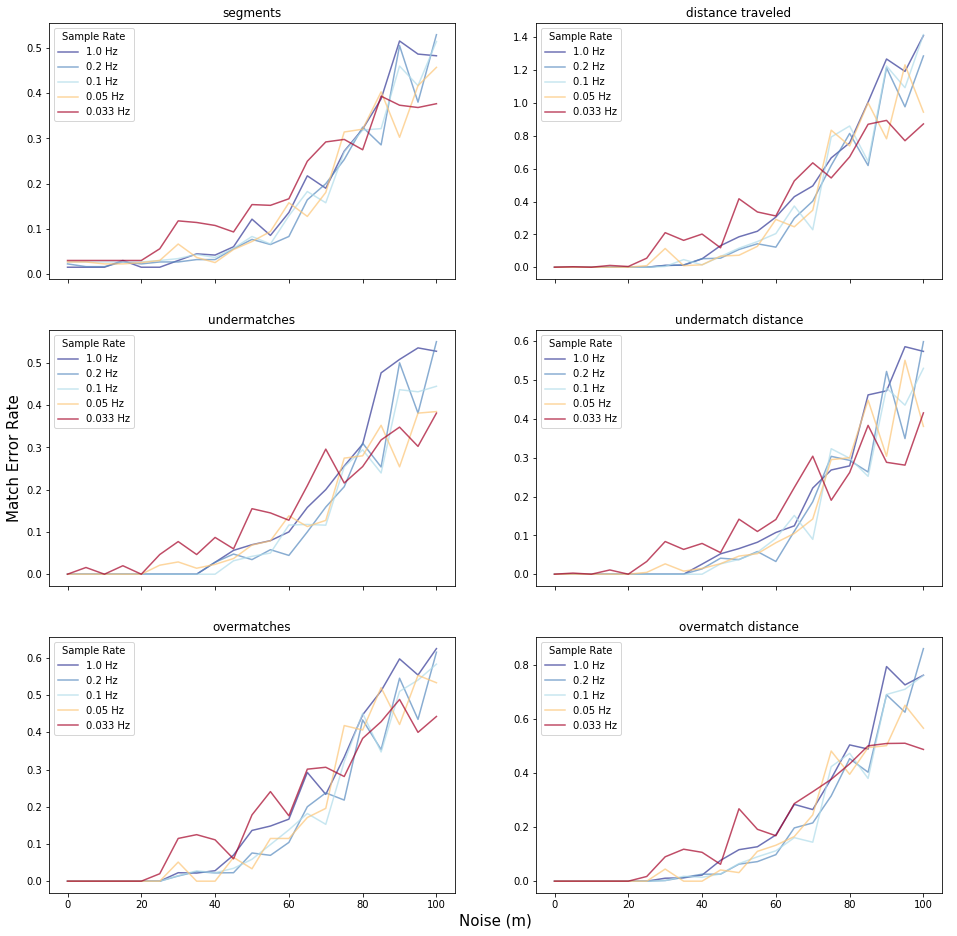

In [34]:
val.plot_distance_metrics(matchDf, sampleRates)

## 6. Post-processing with Speed-based Metrics

Mapzen's map-matching algorithm relies on a kind of graphical model known as a Hidden Markov Model (HMM). Because HMM's are probabilistic in nature, the match returned by the algorithm will always be a best guess. However, this best guess may still be far from the "truth". Thus, we would like some method for filtering out match results that just aren't realistic. 

Derived segment speeds provide us with one such method for throwing out bad results. Although GPS positional data is often very noisy, its temporal measurements are rarely wrong. Comparing the time (speed) it takes for an agent to traverse a segment to the known speed limit along that segment can provide a very accurate way to filter out erroneous matches.

Below, we attempt to learn from our simulated GPS traces what an optimal speed-error threshold might be for creating such a filter.

#### Calculate and plot the optimal speed error threshold

Below, the optimal speed threshold is defined by the percent error that maximizes the difference between the True Positive Rate and the False Positive rate. The graph below shows both of these rates functions of the percent error of segment speed. The hypothesis is that road segments incorrectly matched by the Reporter are more likely to have unreasonably high speeds due to the tendency of misidentified routes to follow detours that are nearly impossible to traverse in the amount of time elapsed during the traversal of the actual route.

Referring back to the image of "distance traveled error" taken from the Newton and Krumm (2009) paper above, the erroneous route would clearly take longer to traverse. In order to traverse this route in the same amount of time  elapsed as in the original measurements, the speed would need to be nearly double. These are the types of outliers that we wish to catch by defining a hard filter threshold.

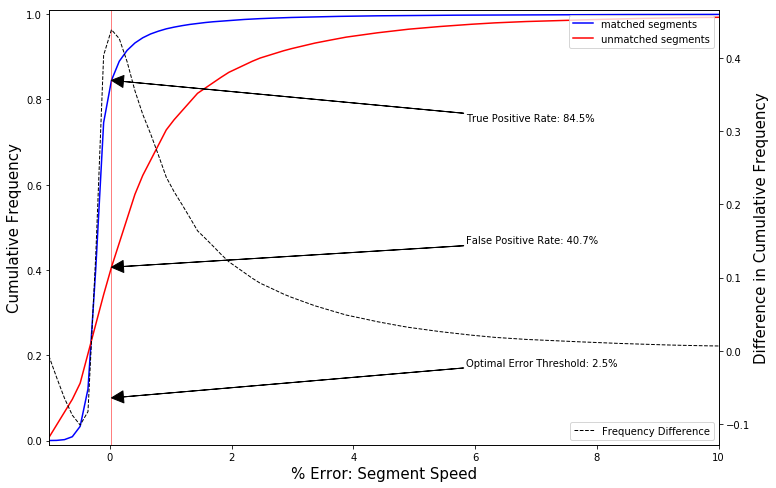

In [8]:
speedErrorThreshold = val.get_optimal_speed_error_threshold(speedDf, plot=True)

The chart above clearly shows that nearly 90% of correctly matched segments have a speed error rate of less than 2.5%, while nearly 60% of the unmatched segments, or false positive matches, lie above this value.

It should be taken with a grain of salt that the optimal error value in this instance is so close to 0. For one, the OpenStreetMap derived speeds being used to compare against are probably as accurate in San Francisco as they are anywhere in the world. Furthermore, the speeds we are using to generate the synthetic GPS data, which we need to perform the resampling of points along the route, are the very same speeds we are later comparing against when we calculate the error rates. Real world data will likely vary much greater with respect to the OSM-derived speeds.

#### Map Matching Accuracy Using One-Size-Fits-All Speed Error Threshold

How accurate would our data collection and aggregation process be using the threshold derived above?  We can use the measure of statistical accuracy to answer that question, and visualize how the accuracies compare across different sample rates and levels of noise.

Statistical accuracy measures the fraction of samples correctly identified as either true positives or true negatives, or in our case, matches and misses, respectively.

$$ \text{Accuracy} = \frac{\text{True Positives} \ + \ \text{True Negatives}}{\text{Total Population}} =  \frac{\text{# Matches Kept} \ + \ \text{# Misses Discarded}}{\text{# Segments}}$$

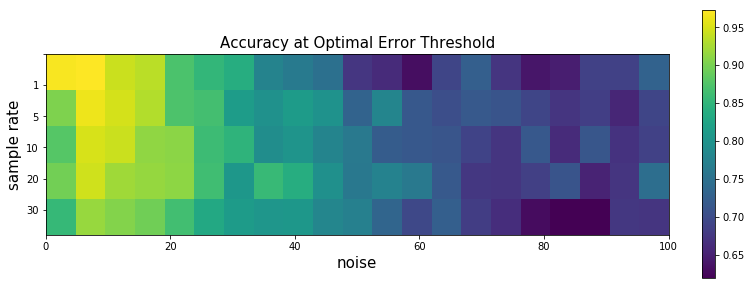

In [36]:
oneSizeFitsAll = val.plot_accuracy_heatmap(speedDf, [speedErrorThreshold], sampleRates, noiseLevels)

#### Calculate optimal thresholds for each sample rate

GPS sample rate is likely to be fixed for a given data provider. We can thus tune our cutoff threshold based on the sample rate which should improve the accuracy of our matches overall.

In [23]:
thresholdRateDict = {}
thresholdsByRate = []
for r, rate in enumerate(sampleRates):
    df = speedDf[speedDf['sample_rate'] == rate]
    threshold = val.get_optimal_speed_error_threshold(df, plot=False, saveFig=False)
    thresholdsByRate.append(threshold)
    thresholdRateDict[str(int(sampleRates[r]))] = threshold

In [24]:
thresholdRateDict

{'1': -0.042885907591220018,
 '10': 0.12259286172616979,
 '20': 0.099837274612300186,
 '30': 0.071563534379066596,
 '5': 0.086051105279773443}

We can now recalculate the statistical accuracy using the rate-specific thresholds...

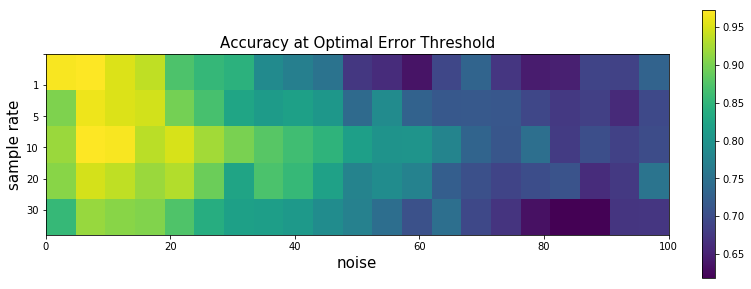

In [39]:
accBySampleRate = val.plot_accuracy_heatmap(speedDf, thresholdsByRate, sampleRates, noiseLevels)

...and visualize the change between the two:

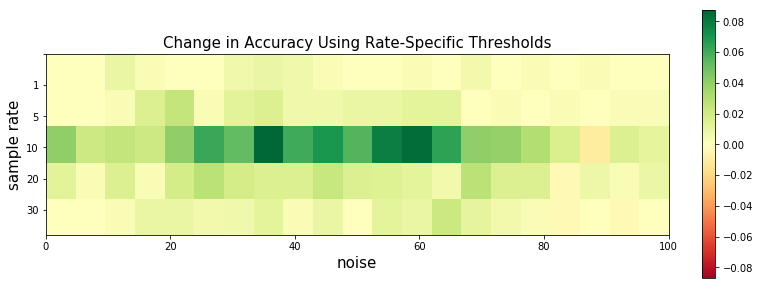

In [40]:
val.plot_change_in_acc(oneSizeFitsAll, accBySampleRate, sampleRates, noiseLevels)

These charts suggest that prior knowledge of GPS sample rate can result in accuracy gains of up to 8% using the optimal speed error threshold.

#### Geographic Classification

Similar to the parameter optimzation, choosing speed error thresholds is another area of map-matching that would significantly benefit from the creation of designated metro regions based on expected GPS accuracy.

#### Weighted penalty function

We need not default to the "optimal" speed error threshold, which treats false positives and false negatives as equally "bad". For example, if a given customer/data provider cares more about mistakenly including bad data (Type I error) than missing good data (Type II error) a more conservative threshold can be set below this optimal value. The CDF plots above allow an analyst to visually inspect the impact that such discretionary adjustments will have on the outcome. These types of adjustments can also be performed in a programmatic fashion by assigning differential weights to our two types of error and thus shifting the optimal value itself.

## 7. Visually Inspect the Speed-Based Filtering

#### Get more routes

In [25]:
vizRoutes = val.get_routes_by_length(cityName, 1, 5, 10, mapzenKey)

#### Synthesize the GPS traces and apply our learned parameters and thresholds

It might be a good idea to pick a single noise level or sample rate since we are no longer interested in generating aggregate statistics. We just want to see the outcome of all the work we've been doing!

In [29]:
noiseLevels = np.linspace(0, 100, 21)
noiseLevels = [50]
sampleRates = [1, 5, 10, 20, 30]
sampleRates = [10]

We are once again calling the `get_route_metrics()` function, but we now have intelligently derived values for $\sigma_z$, $\beta$, and the speed error threshold:

In [31]:
matchDf, speedDf = val.get_route_metrics(
    vizRoutes, sampleRates, noiseLevels, sigmaZ=sigmaZ, beta=beta,
    speedErrThreshold=thresholdRateDict[str(sampleRates[0])])

Route: 0 // Noise Level: 50.0 // Sample Rate: 10
Route: 1 // Noise Level: 50.0 // Sample Rate: 10
Route: 2 // Noise Level: 50.0 // Sample Rate: 10
Route: 3 // Noise Level: 50.0 // Sample Rate: 10
Route: 4 // Noise Level: 50.0 // Sample Rate: 10
Route: 5 // Noise Level: 50.0 // Sample Rate: 10
Route: 6 // Noise Level: 50.0 // Sample Rate: 10
Route: 7 // Noise Level: 50.0 // Sample Rate: 10
Route: 8 // Noise Level: 50.0 // Sample Rate: 10
Route: 9 // Noise Level: 50.0 // Sample Rate: 10


By defining our speed error threshold as a map-matching setting itself, we can visually inspect the map-matching process that we have defined based on the parameters and thresholds we've derived above. We can style the output of our sample routes in order to highlight the segments and their speeds that will either make their way into the datastore or get thrown out. This is simply a way of visualizing the process that in practice would occur dynamically, and entirely behind-the-scenes. 

In the maps below, the original route used to generate the fake GPS measurements are shown in **<span style="color:orange">orange</span>**, along with the points along these routes that were resampled at the specified sample rate. The perturbed points that constitute the synthetic GPS measurements themselves are shown in **<span style="color:blue">blue</span>**, along with the matched route that was based on the fake GPS data. Segments along this matched route are colored differentially based on the specified speed error threshold. Segments that exceeded the threshold are shown in ** <span style="color:red">red</span>**, while segments that did not exceed the threshold are shown in  **<span style="color:green">green</span>**. Segments for whom a consistent match could not be found are shown in  **<span style="color:yellow">yellow</span>**.

Run the following cell as many times as you like to select a random route from among those you just simulated, and view it on a map: 

In [32]:
geojsonList = [trace for trace in os
               .listdir('../data/') if trace.endswith('json')]
fname = '../data/' + choice(geojsonList)
val.generate_route_map(fname, 14)

## 8. Interregional Comparisons

Apart setting the sample rate of GPS collection, tuning the map-matching parameters, and imparting some domain knowledge about automobile speeds, there are certain factors beyond our control that will heavily influence the performance of the algorithm. The single most important of these is the built environment. Things like road network density and building height can severely impact the reliability of the HMM predictions, as well as the GPS measurements upon which they depend.

It is thus worthwhile to compare the performance across regions. In practice, the algorithm parameters and post-processing thresholds can be customized to match the character of a given region. And some regions can reasonably expect better or worse performance of map-matching along these lines. This is one reason why it is so important to be able to make an informed decision about how to weight the importance of Type I error vs Type II error.

For the purposes of this demonstration, however, we will simply compare the performance of what we've already seen in San Francisco, a city of relatively high road network density, to another, more suburban locale in the United Sates: Prescott, AZ.

### Prescott, AZ

In [9]:
cityName = 'Prescott, AZ'
routeList = val.get_routes_by_length(cityName, 1, 5, 100, mapzenKey)

In [44]:
noiseLevels = np.linspace(0, 100, 21)
sampleRates = [1, 5, 10, 20, 30]
azMatchDf, _ = val.get_route_metrics(routeList, sampleRates, noiseLevels, saveResults=False)

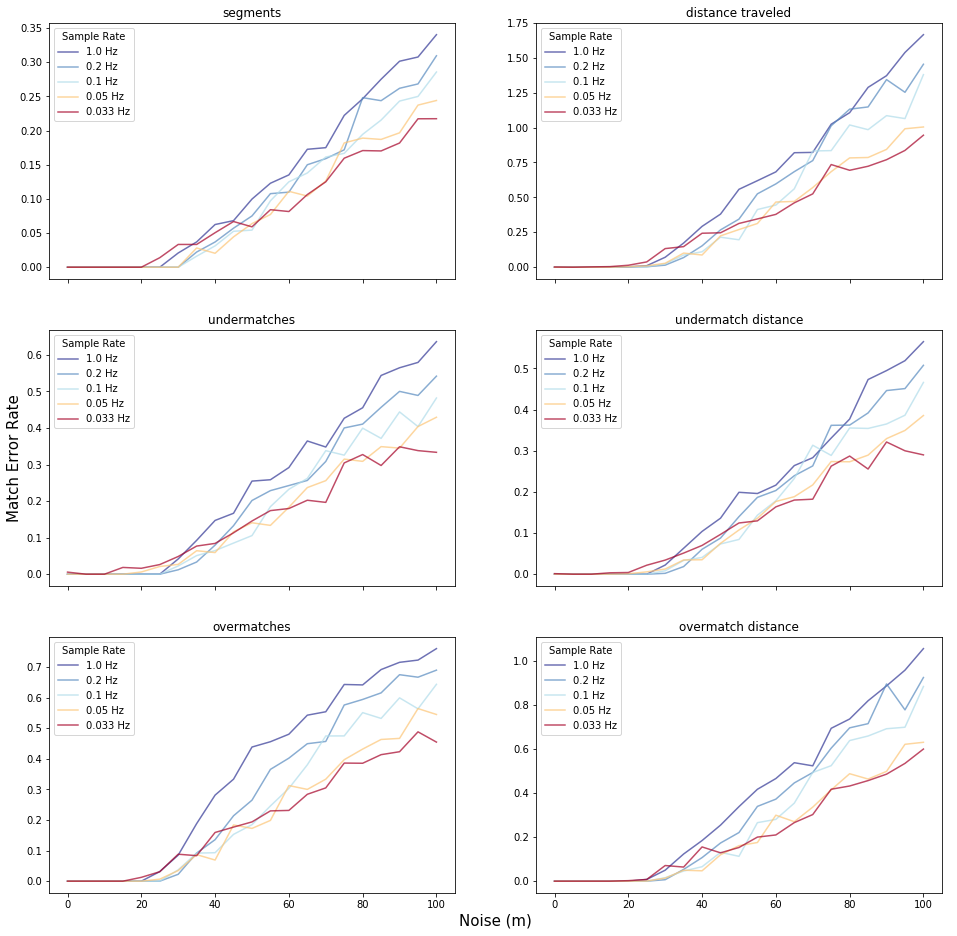

In [43]:
val.plot_distance_metrics(azMatchDf, sampleRates)

### Prescott, AZ vs. San Francisco, CA

In [11]:
sfMatchDf = pd.read_csv('sf_100_matches.csv')

In [12]:
sfMedianScores = sfMatchDf[['noise','sample_rate','distance traveled']].groupby(['noise','sample_rate']).agg('median').reset_index()
azMedianScores = azMatchDf[['noise','sample_rate','distance traveled']].groupby(['noise','sample_rate']).agg('median').reset_index()

In [13]:
merged = pd.merge(sfMedianScores, azMedianScores, on=['noise','sample_rate'], suffixes=('_sf','_az'))
merged['diff'] = merged['distance traveled_sf'] - merged['distance traveled_az']

In [46]:
sfDens = round(sfMatchDf['avg_density'].median(), 2)
azDens = round(azMatchDf['avg_density'].median(), 2)

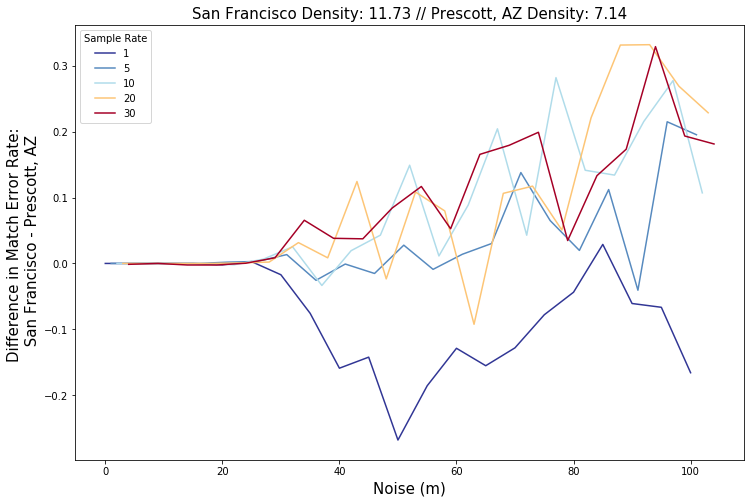

In [51]:
fig, ax = plt.subplots(figsize=(12, 8))
norm = plt.Normalize()
cmap = plt.get_cmap('RdYlBu_r')
colors = cmap(norm(sampleRates))
for r, rate in enumerate(sampleRates):
    ax.plot(merged.loc[merged['sample_rate'] == rate, 'diff'], label=rate, color=colors[r])
ax.set_xlabel('Noise (m)', fontsize=15)
ax.set_ylabel('Difference in Match Error Rate: \n San Francisco - Prescott, AZ', fontsize=15)
ax.set_title('San Francisco Density: {0} // Prescott, AZ Density: {1}'.format(
    sfDens, azDens), fontsize=15)
ax.legend(title='Sample Rate')

The plot above doesn't tell us much about the effect of road network density, but there appears to be a significant distiction between sample rates above and below 1.01 Hz. If we aggregate the results based on this threshold, a much more telling pattern emerges:

In [52]:
binary = merged.groupby([merged['sample_rate'] > 1, merged['noise']]).agg('median')['diff'].reset_index()

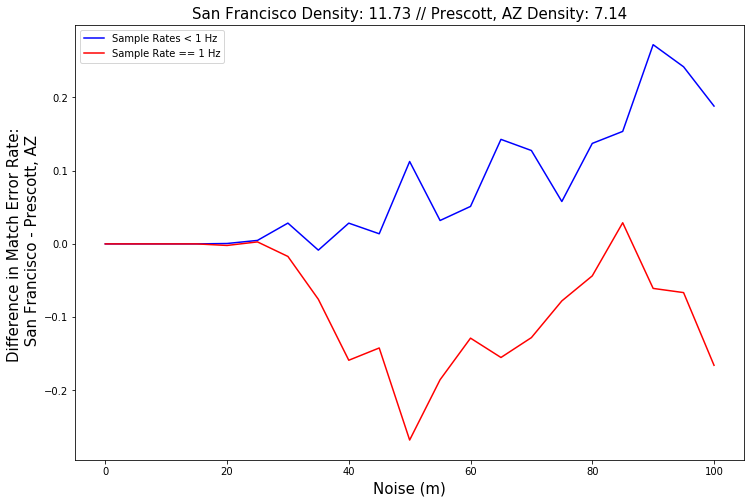

In [54]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(
    binary.loc[binary['sample_rate'] == True,'noise'],
    binary.loc[binary['sample_rate'] == True,'diff'],
    label='Sample Rates < 1 Hz', color='b'
)
ax.plot(
    binary.loc[binary['sample_rate'] == False,'noise'],
    binary.loc[binary['sample_rate'] == False,'diff'],
    label='Sample Rate == 1 Hz', color='r'
)
ax.legend()
ax.set_title('San Francisco Density: {0} // Prescott, AZ Density: {1}'.format(
    sfDens, azDens), fontsize=15)
ax.set_xlabel('Noise (m)', fontsize=15)
ax.set_ylabel('Difference in Match Error Rate: \n San Francisco - Prescott, AZ', fontsize=15)

The graph above shows the overall net-positive impact that lower road network density has on algorithm performance, especially at higher noise levels. Lower density metro areas can expect significantly better results than their denser counterparts, and this is an important message to convey to all Open Traffic stakeholders.

The one glaring deviation from that pattern is the 1 Hz trendline. Road network density appears to have the opposite effect on map-matching for measurements at the highest sampling frequencies. This could merely be an idiosyncracy of the scoring metrics used here. However, the exact mechanism that explains the discrepancy remains unclear, and should be a topic for further exploration.